In [ ]:
!pip install adabelief-pytorch==0.1.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from adabelief_pytorch import AdaBelief

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
from PIL import Image

import math
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load The Classification Data

In [ ]:
def parse_data(datadir):
    img_list = []
    ID_list = []
    for root, directories, filenames in os.walk(datadir):  #root: median/1
        for filename in filenames:
            if filename.endswith('.jpg'):
                filei = os.path.join(root, filename)
                img_list.append(filei)
                ID_list.append(root.split('/')[-1])


    # construct a dictionary, where key and value correspond to ID and target
    uniqueID_list = list(set(ID_list))
    class_n = len(uniqueID_list)
    target_dict = dict(zip(uniqueID_list, range(class_n)))
    label_list = [target_dict[ID_key] for ID_key in ID_list]

    print('{}\t\t{}\n{}\t\t{}'.format('#Images', '#Labels', len(img_list), len(set(label_list))))
    return img_list, label_list, class_n

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, file_list, target_list, transform):
        self.file_list = file_list
        self.target_list = target_list
        self.classes = len(list(set(target_list)))
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img = self.transform(img)
        label = self.target_list[index]

        return img, label

In [ ]:
root_path = "/content/drive/MyDrive/Data/ICS_471_Project/CCSN_v2"

split_factor = 0.7

#new_size is used to unify all the image sizes. 
new_size = 400

crop_image_size = 150

data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.FiveCrop(crop_image_size),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))])

img_list, label_list, num_classes = parse_data(root_path)

#Split the data into train and validation datasets
train_list, test_list, train_label, test_label = train_test_split(img_list, label_list, train_size=split_factor, shuffle=True)
train_dataset = ImageDataset(train_list, train_label, data_transforms)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1, drop_last=False)

val_dataset = ImageDataset(test_list, test_label, data_transforms)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=1, drop_last=False)

print(f"Split Factor  = {split_factor}")
print(f"train_dataset = {train_dataset.__len__()}")
print(f"val_dataset   = {val_dataset.__len__()}")

#Images		#Labels
2543		11
Split Factor  = 0.7
train_dataset = 1780
val_dataset   = 763


Batch Size with Crop = torch.Size([10, 5, 3, 150, 150]) = [batch_size, #crop, channels, width, height]
Batch Size without Crop = torch.Size([50, 3, 150, 150]) = [new_batch_size, channels, width, height]
img shape = (3, 150, 150)


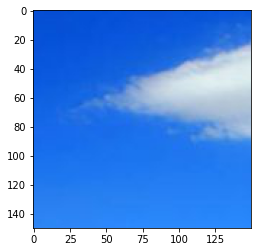

In [ ]:
'''
  Using five crop or ten crop will requrie some modifiction to read the images.
  Note: Batch size = batch_size * (five crop OR ten crop)
'''
for batch, target in train_loader:
    print(f"Batch Size with Crop = {batch.shape} = [batch_size, #crop, channels, width, height]")
    bs, ncrops, c, h, w = batch.size() 
    batch = batch.view(-1,c,h,w)
    print(f"Batch Size without Crop = {batch.shape} = [new_batch_size, channels, width, height]")

    batch = batch.numpy()
    for img, label in zip(batch, target):
        print(f"img shape = {img.shape}")
        plt.imshow(img.transpose((1,2,0)))
        plt.show()
        break
    break

## Center Loss

In [ ]:
class CenterLoss(nn.Module):
    """
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes, feat_dim, device=torch.device('cpu')):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss

## Training and Validation Routine with Center Loss 

In [ ]:
def train_closs(model, train_loader, val_loader, criterion_label, criterion_closs, optimizer_label, optimizer_closs, closs_weight = 1, numEpochs = 10):
    model.train()

    for epoch in range(numEpochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_loader):
            bs, ncrops, c, h, w = feats.size()
            feats = feats.view(-1,c,h,w)
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer_label.zero_grad()
            optimizer_closs.zero_grad()
            
            feature, outputs = model(feats)

            feature = feature.view(bs, ncrops, -1).mean(1)
            outputs = outputs.view(bs, ncrops, -1).mean(1)

            l_loss = criterion_label(outputs, labels.long())
            c_loss = criterion_closs(feature, labels.long())
            loss = l_loss + closs_weight * c_loss
            
            loss.backward()
            
            optimizer_label.step()
            # by doing so, weight_cent would not impact on the learning of centers
            for param in criterion_closs.parameters():
                param.grad.data *= (1. / closs_weight)
            optimizer_closs.step()
            
            avg_loss += loss.item()

            if batch_num % 50 == 49:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        
        val_loss, val_acc = test_classify_closs(model, val_loader, criterion_label, criterion_closs)
        train_loss, train_acc = test_classify_closs(model, train_loader, criterion_label, criterion_closs)
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
              format(train_loss, train_acc, val_loss, val_acc))
        
        if epoch%100 == 0 and epoch != 0:
            state = {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer_label": optimizer_label.state_dict(),
                "optimizer_closs": optimizer_closs.state_dict(),
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            }

            torch.save(state, f'/content/drive/MyDrive/Models/ICS-471_Project/net1/model_epoch_{epoch}.pt')
            print(f"Model for epoch = {epoch} is saved")
        

def test_classify_closs(model, test_loader, criterion_label, criterion_closs, closs_weight = 1):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        bs, ncrops, c, h, w = feats.size()
        feats = feats.view(-1,c,h,w)
        
        feats, labels = feats.to(device), labels.to(device)

        feature, outputs = model(feats)

        feature = feature.view(bs, ncrops, -1).mean(1)
        outputs = outputs.view(bs, ncrops, -1).mean(1)
        
        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        l_loss = criterion_label(outputs, labels.long())
        c_loss = criterion_closs(feature, labels.long())
        loss = l_loss + closs_weight * c_loss
        
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total

## Network

In [ ]:
class Network(nn.Module):
    def __init__(self, CNN_layers, CNN_layers_output, num_classes, feat_dim=10):
        super(Network, self).__init__()
        
        self.layers = []
        self.layers = nn.Sequential(*CNN_layers)

        self.linear_label = nn.Linear(CNN_layers_output, num_classes, bias=False)
        
        # For creating the embedding to be passed into the Center Loss criterion
        self.linear_closs = nn.Linear(CNN_layers_output, feat_dim, bias=False)
        self.relu_closs = nn.ReLU(inplace=True)
    
    def forward(self, x, evalMode=False):
        output = x
        output = self.layers(output)
        output = F.avg_pool2d(output, [output.size(2), output.size(3)], stride=1)
        output = output.reshape(output.shape[0], output.shape[1])
        
        label_output = self.linear_label(output)
        label_output = label_output/torch.norm(self.linear_label.weight, dim=1)
        
        # Create the feature embedding for the Center Loss
        closs_output = self.linear_closs(output)
        closs_output = self.relu_closs(closs_output)

        return closs_output, label_output

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)

#### Network (Net1)


#### Network (Net2)


## Classification Training with Center Loss

In [ ]:
epoch = 20000

#### Network (Net1)

##### Load Saved Net1

##### Saved Net1 Results

#### Network (Net2)

##### Load Saved Net2

##### Saved Net2 Results